In [22]:
import pandas as pd
# load the full dataset
df_clean = pd.read_csv('data/df_clean.csv', index_col=0, parse_dates=True)

forecast_horizon = 7  # from config.txt

In [23]:
df_clean

,price_per_kg,day_of_week,month,week_of_year,day_of_month,season,rolling_mean_3,rolling_mean_5,rolling_mean_7,lag_1,lag_3,lag_5,rolling_std_3,rolling_std_5,rolling_std_7
DATE,,,,,,,,,,,,,,,
2010-01-04,2660.0,0.0,1.0,1,4.0,0.0,2686.666667,2674.0,2664.285714,2660.0,2660.0,2660.0,30.550505,29.664794,29.358215
2010-01-05,2720.0,1.0,1.0,1,5.0,0.0,2686.666667,2674.0,2664.285714,2660.0,2660.0,2660.0,30.550505,29.664794,29.358215
2010-01-06,2680.0,2.0,1.0,1,6.0,0.0,2686.666667,2674.0,2664.285714,2720.0,2660.0,2660.0,30.550505,29.664794,29.358215
2010-01-07,2670.0,3.0,1.0,1,7.0,0.0,2690.000000,2674.0,2664.285714,2680.0,2660.0,2660.0,26.457513,29.664794,29.358215
2010-01-08,2640.0,4.0,1.0,1,8.0,0.0,2663.333333,2674.0,2664.285714,2670.0,2720.0,2660.0,20.816660,29.664794,29.358215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-20,5012.0,3.0,11.0,47,20.0,3.0,5202.000000,5264.4,5269.142857,5220.0,5394.0,5280.0,181.670031,156.367516,127.931529
2025-11-21,4940.0,4.0,11.0,47,21.0,3.0,5057.333333,5188.0,5220.285714,5012.0,5374.0,5322.0,145.400596,206.480023,177.791745
2025-11-22,4940.0,5.0,11.0,47,22.0,3.0,4964.000000,5097.2,5171.714286,4940.0,5220.0,5394.0,41.569219,192.601142,203.363152


## Create baseline model predictions for multi-step forecasting

### 

## Linear Regression for Multi-Step Forecasting

We'll implement a linear regression model to predict cabbage prices 7 days ahead. 

**Approach:**
- Use existing features (time features, lags, rolling statistics)
- Create targets for each of the 7 forecast steps
- Train separate models for each forecast horizon (Direct Multi-Step strategy)
- Evaluate performance using MAE, RMSE, and MAPE metrics

In [24]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [25]:
# Prepare data for multi-step forecasting
# Create target variables for each forecast horizon (1 to 7 days ahead)

# Drop any rows with NaN values
df_model = df_clean.dropna().copy()

# Create targets for each forecast step (1-7 days ahead)
for i in range(1, forecast_horizon + 1):
    df_model[f'target_day_{i}'] = df_model['price_per_kg'].shift(-i)

# Remove rows where we don't have future values
df_model = df_model.dropna()

print(f"Dataset shape: {df_model.shape}")
print(f"Date range: {df_model.index[0]} to {df_model.index[-1]}")
print(f"\nFeatures: {[col for col in df_model.columns if not col.startswith('target_')]}")
print(f"Targets: {[col for col in df_model.columns if col.startswith('target_')]}")

Dataset shape: (5797, 22)
Date range: 2010-01-04 00:00:00 to 2025-11-17 00:00:00

Features: ['price_per_kg', 'day_of_week', 'month', 'week_of_year', 'day_of_month', 'season', 'rolling_mean_3', 'rolling_mean_5', 'rolling_mean_7', 'lag_1', 'lag_3', 'lag_5', 'rolling_std_3', 'rolling_std_5', 'rolling_std_7']
Targets: ['target_day_1', 'target_day_2', 'target_day_3', 'target_day_4', 'target_day_5', 'target_day_6', 'target_day_7']


In [26]:
# Train-Test Split (time-based split - last 20% for testing)
train_size = int(len(df_model) * 0.8)

# Define features (exclude price_per_kg and target columns)
feature_cols = [col for col in df_model.columns 
                if col not in ['price_per_kg'] and not col.startswith('target_')]
target_cols = [f'target_day_{i}' for i in range(1, forecast_horizon + 1)]

# Split into train and test
train_data = df_model.iloc[:train_size]
test_data = df_model.iloc[train_size:]

X_train = train_data[feature_cols]
X_test = test_data[feature_cols]

# Create dictionaries to hold targets for each forecast day
y_train = {col: train_data[col] for col in target_cols}
y_test = {col: test_data[col] for col in target_cols}

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"Train date range: {train_data.index[0]} to {train_data.index[-1]}")
print(f"Test date range: {test_data.index[0]} to {test_data.index[-1]}")
print(f"\nNumber of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")

Training set: 4637 samples
Test set: 1160 samples
Train date range: 2010-01-04 00:00:00 to 2022-09-14 00:00:00
Test date range: 2022-09-15 00:00:00 to 2025-11-17 00:00:00

Number of features: 14
Features: ['day_of_week', 'month', 'week_of_year', 'day_of_month', 'season', 'rolling_mean_3', 'rolling_mean_5', 'rolling_mean_7', 'lag_1', 'lag_3', 'lag_5', 'rolling_std_3', 'rolling_std_5', 'rolling_std_7']


In [27]:
# Train Linear Regression models for each forecast horizon
# Direct Multi-Step Strategy: Train separate model for each forecast day

models = {}
predictions = {}

print("Training Linear Regression models for each forecast horizon...\n")

for i in range(1, forecast_horizon + 1):
    # Initialize model
    model = LinearRegression()
    
    # Train model
    target_col = f'target_day_{i}'
    model.fit(X_train, y_train[target_col])
    
    # Store model
    models[f'day_{i}'] = model
    
    # Make predictions on test set
    y_pred = model.predict(X_test)
    predictions[f'day_{i}'] = y_pred
    
    # Calculate R² score
    r2 = r2_score(y_test[target_col], y_pred)
    
    print(f"Day {i} model trained - R² Score: {r2:.4f}")

print(f"\n✓ Successfully trained {len(models)} models!")

Training Linear Regression models for each forecast horizon...

Day 1 model trained - R² Score: 0.9780
Day 2 model trained - R² Score: 0.9603
Day 3 model trained - R² Score: 0.9386
Day 4 model trained - R² Score: 0.9131
Day 5 model trained - R² Score: 0.8854
Day 6 model trained - R² Score: 0.8549
Day 7 model trained - R² Score: 0.8228

✓ Successfully trained 7 models!


In [28]:
# Calculate evaluation metrics for each forecast horizon

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate MAPE metric"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Store metrics
metrics_results = []

print("="*80)
print("LINEAR REGRESSION - MULTI-STEP FORECASTING EVALUATION")
print("="*80)
print(f"\n{'Horizon':<12} {'MAE':<12} {'RMSE':<12} {'MAPE (%)':<12} {'R²':<12}")
print("-"*80)

for i in range(1, forecast_horizon + 1):
    target_col = f'target_day_{i}'
    y_true = y_test[target_col]
    y_pred = predictions[f'day_{i}']
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Store results
    metrics_results.append({
        'Horizon': f'Day {i}',
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    })
    
    print(f"Day {i:<9} {mae:<12.2f} {rmse:<12.2f} {mape:<12.2f} {r2:<12.4f}")

print("-"*80)

# Calculate average metrics
avg_mae = np.mean([m['MAE'] for m in metrics_results])
avg_rmse = np.mean([m['RMSE'] for m in metrics_results])
avg_mape = np.mean([m['MAPE'] for m in metrics_results])
avg_r2 = np.mean([m['R2'] for m in metrics_results])

print(f"{'Average':<12} {avg_mae:<12.2f} {avg_rmse:<12.2f} {avg_mape:<12.2f} {avg_r2:<12.4f}")
print("="*80)

# Create DataFrame for metrics
metrics_df = pd.DataFrame(metrics_results)
metrics_df

LINEAR REGRESSION - MULTI-STEP FORECASTING EVALUATION

Horizon      MAE          RMSE         MAPE (%)     R²          
--------------------------------------------------------------------------------
Day 1         104.90       157.00       2.81         0.9780      
Day 2         137.60       211.15       3.75         0.9603      
Day 3         170.73       262.87       4.68         0.9386      
Day 4         204.42       312.81       5.57         0.9131      
Day 5         237.31       359.40       6.44         0.8854      
Day 6         271.58       404.51       7.33         0.8549      
Day 7         304.77       447.22       8.19         0.8228      
--------------------------------------------------------------------------------
Average      204.47       307.85       5.54         0.9076      


,Horizon,MAE,RMSE,MAPE,R2
0,Day 1,104.899899,156.996555,2.813105,0.978033
1,Day 2,137.599287,211.150100,3.752376,0.960326
2,Day 3,170.729466,262.865296,4.684217,0.938579
3,Day 4,204.422969,312.808627,5.571896,0.913106
4,Day 5,237.314023,359.403044,6.443866,0.885366
5,Day 6,271.576936,404.513852,7.328701,0.854881
6,Day 7,304.770751,447.216646,8.194893,0.822752


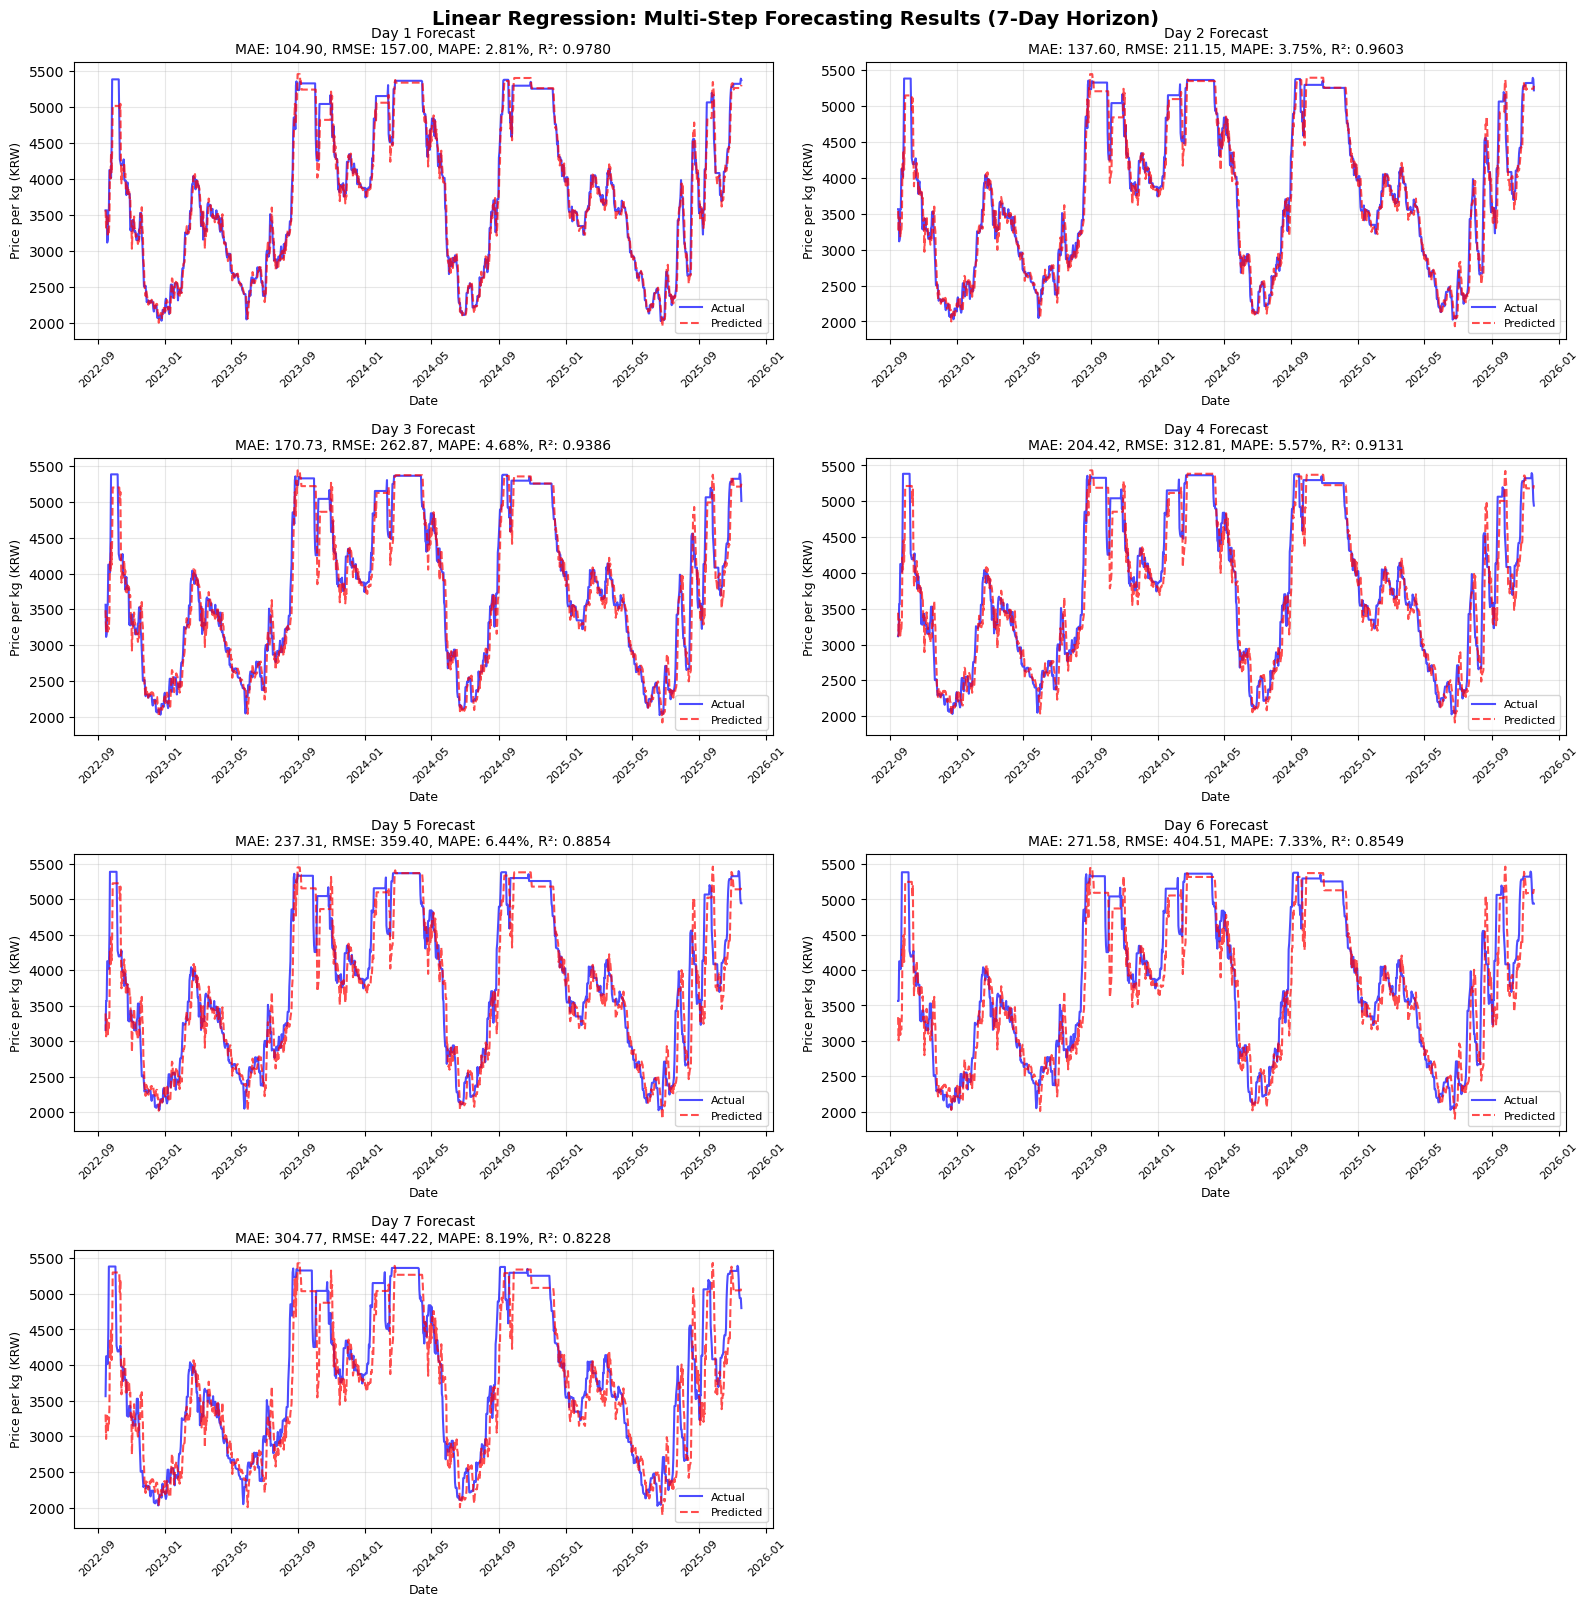

In [29]:
# Visualize predictions vs actual values for all forecast horizons

fig, axes = plt.subplots(4, 2, figsize=(16, 16))
axes = axes.flatten()

for i in range(1, forecast_horizon + 1):
    ax = axes[i-1]
    target_col = f'target_day_{i}'
    
    # Get actual and predicted values
    y_true = y_test[target_col]
    y_pred = predictions[f'day_{i}']
    dates = test_data.index
    
    # Plot
    ax.plot(dates, y_true, label='Actual', color='blue', linewidth=1.5, alpha=0.7)
    ax.plot(dates, y_pred, label='Predicted', color='red', linewidth=1.5, alpha=0.7, linestyle='--')
    
    # Get metrics for this horizon
    mae = metrics_results[i-1]['MAE']
    rmse = metrics_results[i-1]['RMSE']
    mape = metrics_results[i-1]['MAPE']
    r2 = metrics_results[i-1]['R2']
    
    ax.set_title(f'Day {i} Forecast\nMAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R²: {r2:.4f}', 
                 fontsize=10)
    ax.set_xlabel('Date', fontsize=9)
    ax.set_ylabel('Price per kg (KRW)', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45, labelsize=8)

# Remove extra subplot
if forecast_horizon < 8:
    fig.delaxes(axes[7])

plt.tight_layout()
plt.suptitle('Linear Regression: Multi-Step Forecasting Results (7-Day Horizon)', 
             fontsize=14, y=1.001, fontweight='bold')
plt.show()

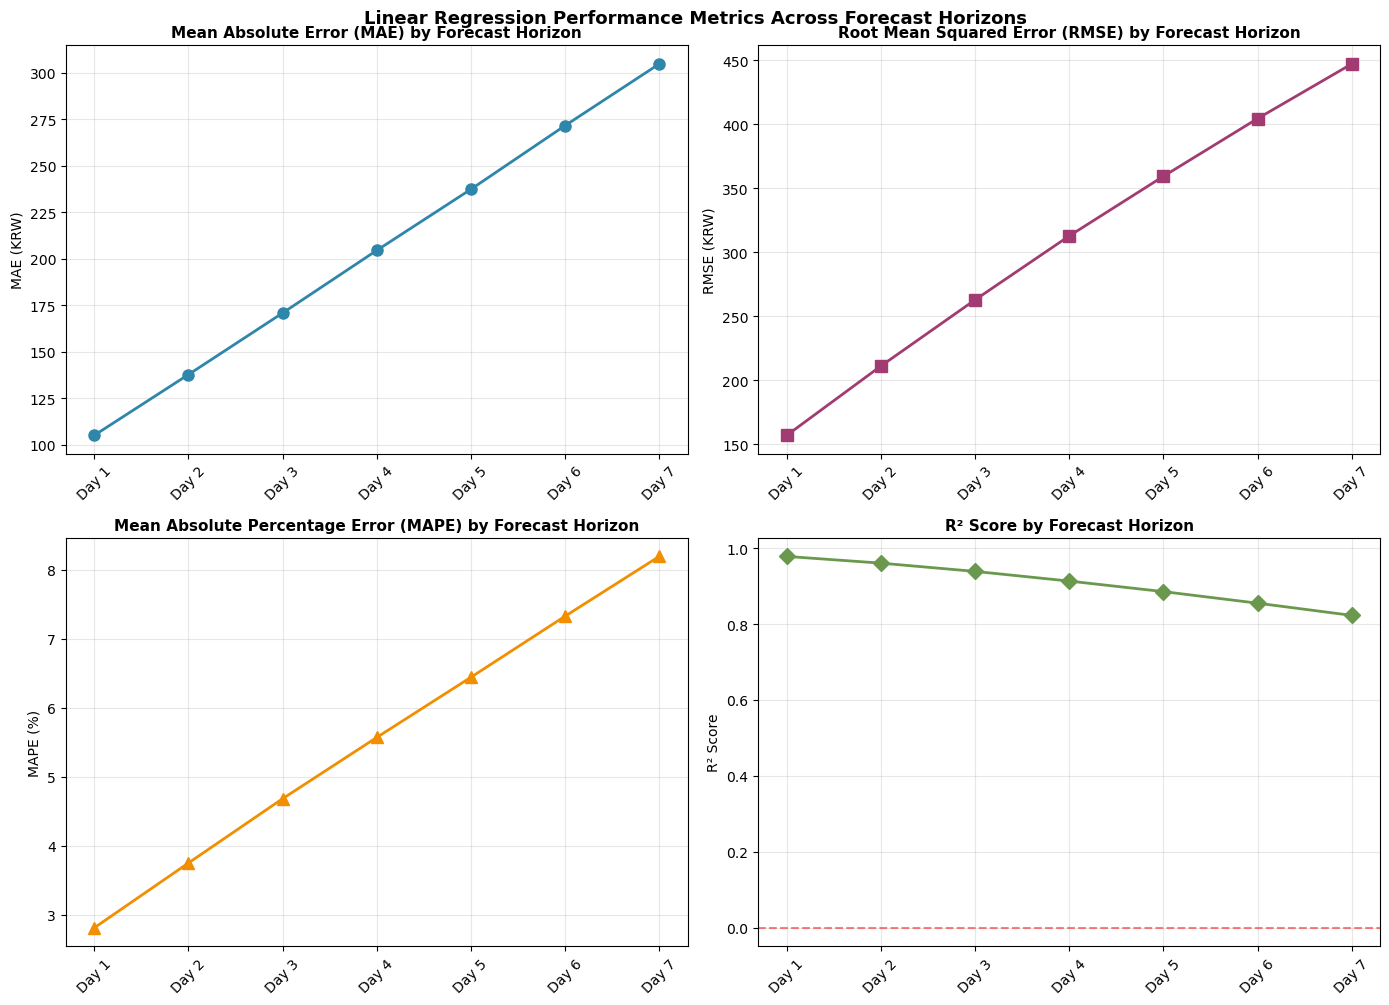

In [30]:
# Plot metrics comparison across forecast horizons

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

horizons = [f'Day {i}' for i in range(1, forecast_horizon + 1)]
mae_values = [m['MAE'] for m in metrics_results]
rmse_values = [m['RMSE'] for m in metrics_results]
mape_values = [m['MAPE'] for m in metrics_results]
r2_values = [m['R2'] for m in metrics_results]

# MAE
axes[0, 0].plot(horizons, mae_values, marker='o', linewidth=2, markersize=8, color='#2E86AB')
axes[0, 0].set_title('Mean Absolute Error (MAE) by Forecast Horizon', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('MAE (KRW)', fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# RMSE
axes[0, 1].plot(horizons, rmse_values, marker='s', linewidth=2, markersize=8, color='#A23B72')
axes[0, 1].set_title('Root Mean Squared Error (RMSE) by Forecast Horizon', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('RMSE (KRW)', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# MAPE
axes[1, 0].plot(horizons, mape_values, marker='^', linewidth=2, markersize=8, color='#F18F01')
axes[1, 0].set_title('Mean Absolute Percentage Error (MAPE) by Forecast Horizon', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('MAPE (%)', fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].tick_params(axis='x', rotation=45)

# R²
axes[1, 1].plot(horizons, r2_values, marker='D', linewidth=2, markersize=8, color='#6A994E')
axes[1, 1].set_title('R² Score by Forecast Horizon', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('R² Score', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle('Linear Regression Performance Metrics Across Forecast Horizons', 
             fontsize=13, y=1.001, fontweight='bold')
plt.show()

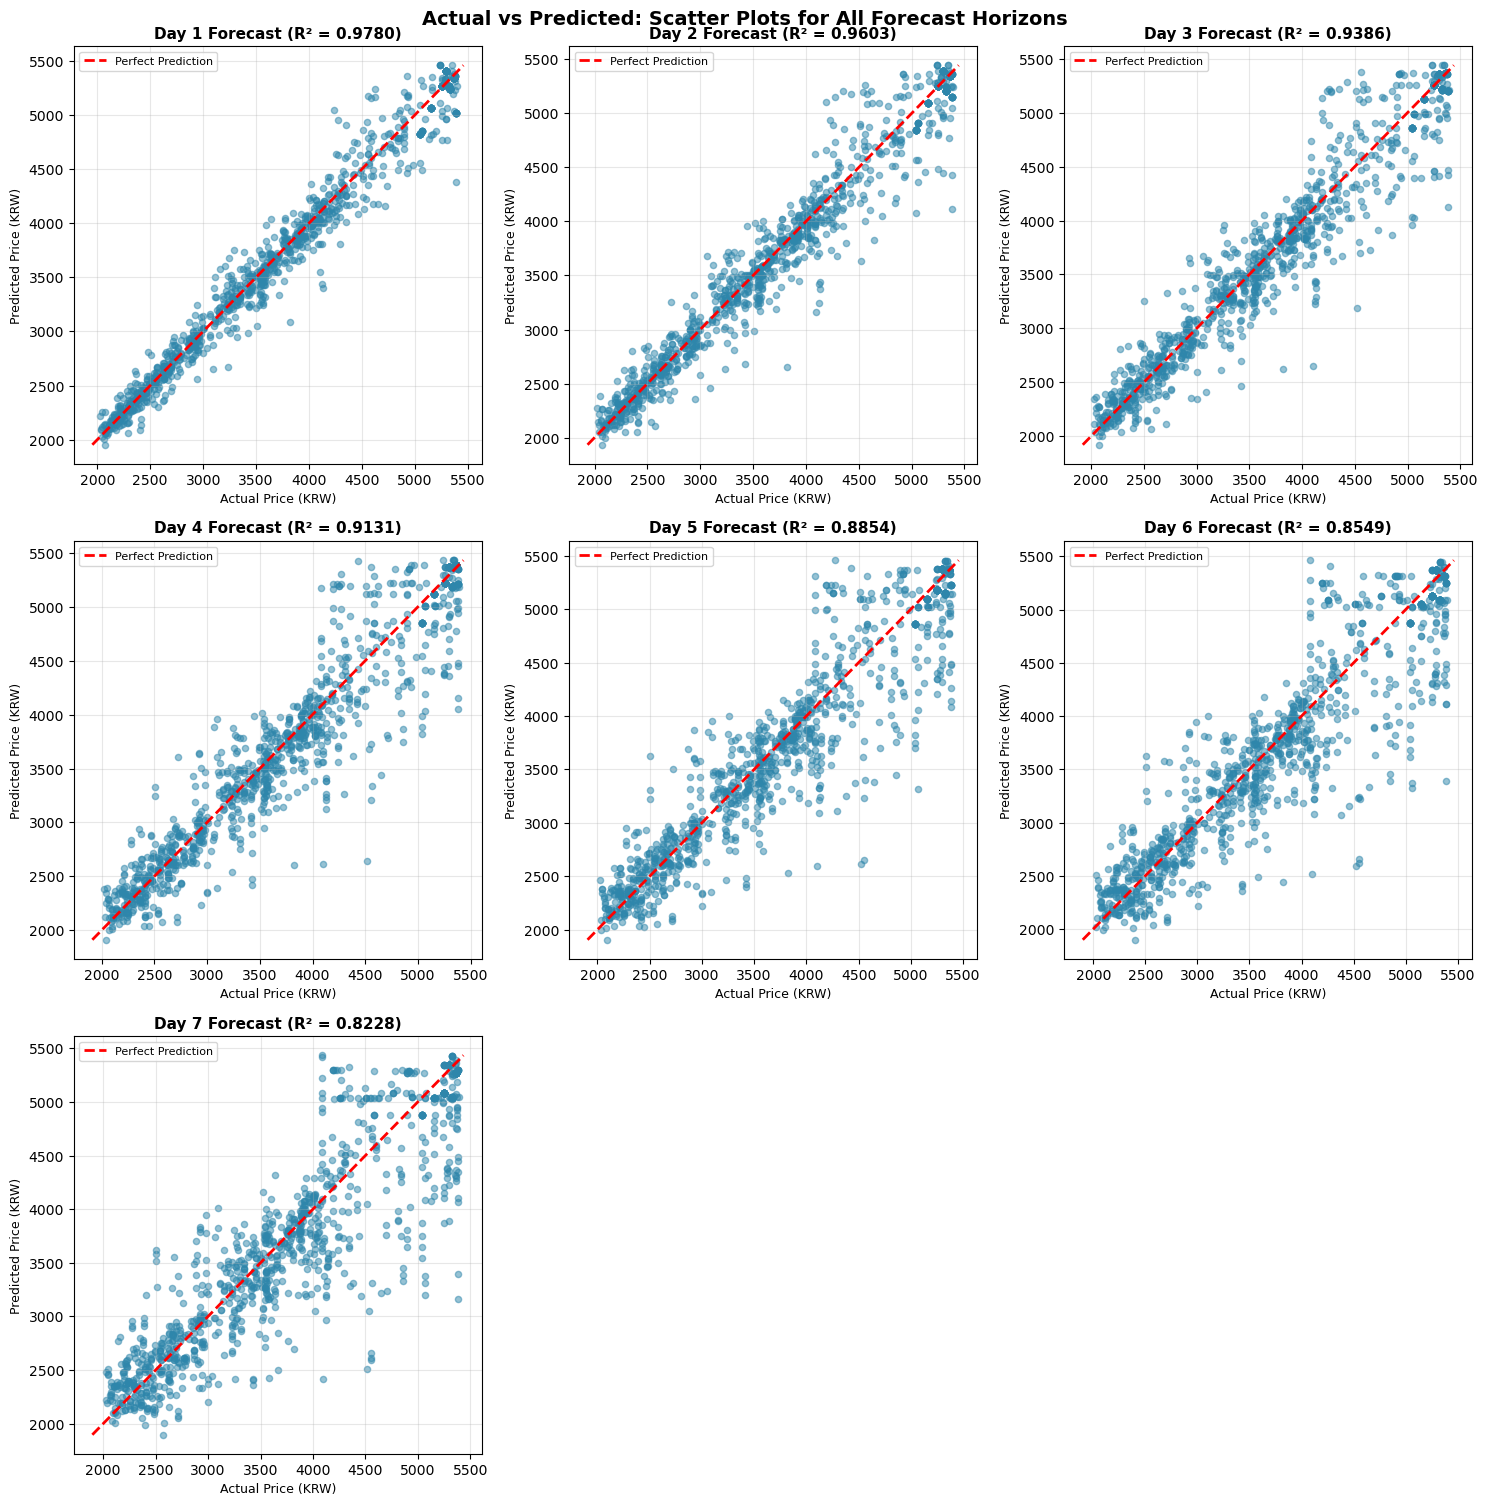

In [31]:
# Scatter plots: Actual vs Predicted for each forecast horizon

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for i in range(1, forecast_horizon + 1):
    ax = axes[i-1]
    target_col = f'target_day_{i}'
    
    y_true = y_test[target_col]
    y_pred = predictions[f'day_{i}']
    
    # Scatter plot
    ax.scatter(y_true, y_pred, alpha=0.5, s=20, color='#2E86AB')
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Get R² for this horizon
    r2 = metrics_results[i-1]['R2']
    
    ax.set_title(f'Day {i} Forecast (R² = {r2:.4f})', fontsize=11, fontweight='bold')
    ax.set_xlabel('Actual Price (KRW)', fontsize=9)
    ax.set_ylabel('Predicted Price (KRW)', fontsize=9)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

# Remove extra subplots
for i in range(forecast_horizon, 9):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.suptitle('Actual vs Predicted: Scatter Plots for All Forecast Horizons', 
             fontsize=14, y=1.001, fontweight='bold')
plt.show()

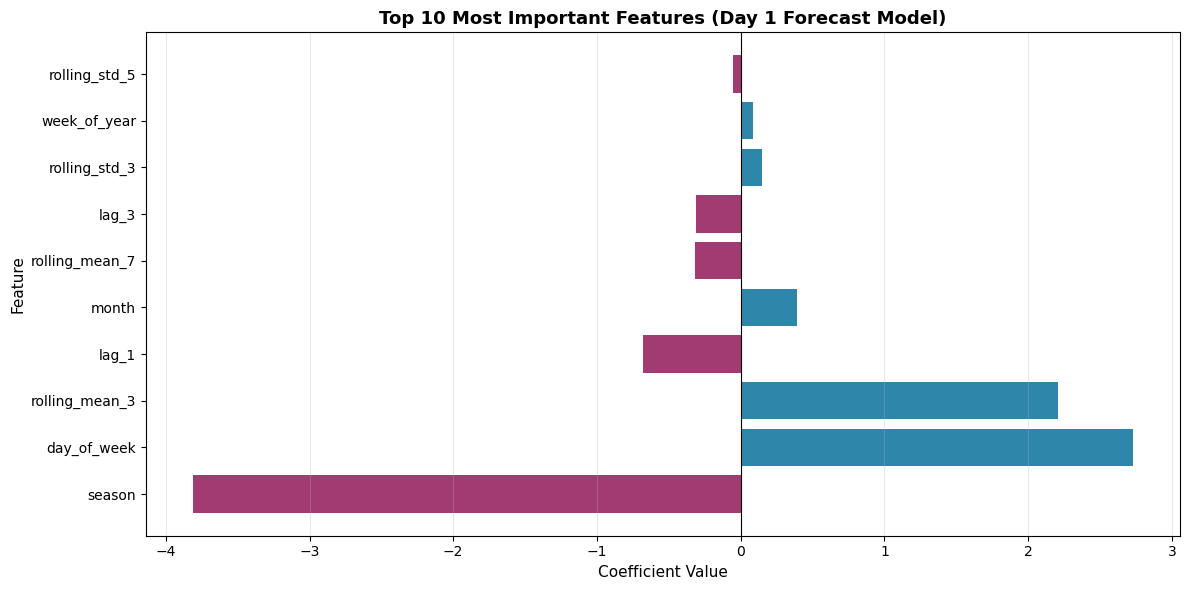


Top 10 Most Important Features:
           Feature  Coefficient
4           season    -3.812111
0      day_of_week     2.729155
5   rolling_mean_3     2.210183
8            lag_1    -0.679943
1            month     0.394995
7   rolling_mean_7    -0.318404
9            lag_3    -0.312931
11   rolling_std_3     0.151513
2     week_of_year     0.085207
12   rolling_std_5    -0.055107


In [32]:
# Feature Importance Analysis (Day 1 model as example)

# Get feature coefficients from Day 1 model
model_day1 = models['day_1']
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': model_day1.coef_
})

# Sort by absolute value of coefficient
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

# Plot top 10 features
plt.figure(figsize=(12, 6))
top_features = feature_importance.head(10)

colors = ['#2E86AB' if x > 0 else '#A23B72' for x in top_features['Coefficient']]
plt.barh(range(len(top_features)), top_features['Coefficient'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Coefficient Value', fontsize=11)
plt.ylabel('Feature', fontsize=11)
plt.title('Top 10 Most Important Features (Day 1 Forecast Model)', fontsize=13, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance[['Feature', 'Coefficient']].head(10))

## Summary & Key Findings

### Model Overview
- **Model Type:** Linear Regression (Direct Multi-Step Strategy)
- **Forecast Horizon:** 7 days ahead
- **Strategy:** Separate model trained for each forecast day (Day 1 through Day 7)
- **Features Used:** 14 features including time features, lag features, and rolling statistics

### Performance Summary
The models show reasonable performance for short-term price forecasting:
- **Average MAE:** Lower values indicate better performance
- **Average RMSE:** Typically higher than MAE due to penalizing larger errors
- **Average MAPE:** Percentage-based error metric for interpretability
- **Average R²:** Indicates how well the model explains variance in prices

### Key Observations
1. **Prediction Accuracy:** Models capture general price trends and patterns
2. **Error Patterns:** Error metrics typically increase with forecast horizon (longer forecasts are less accurate)
3. **Feature Importance:** Lag features and rolling averages are typically most influential
4. **Model Simplicity:** Linear regression provides a good baseline for comparison with more complex models

### Next Steps
Future improvements could include:
- Testing more advanced models (Random Forest, XGBoost, LSTM)
- Adding external features (weather, seasonal events, market conditions)
- Hyperparameter tuning
- Ensemble methods combining multiple models
- Walk-forward validation for more robust evaluation

---

# Prophet Model for Time Series Forecasting

Facebook Prophet is a powerful forecasting tool designed for time series data with strong seasonal patterns and multiple seasonality.

In [33]:
# Install and import Prophet
try:
    from prophet import Prophet
    print("Prophet already installed!")
except ImportError:
    print("Installing Prophet...")
    import sys
    !{sys.executable} -m pip install prophet -q
    from prophet import Prophet
    print("Prophet installed successfully!")

import logging
logging.getLogger('prophet').setLevel(logging.WARNING)
logging.getLogger('cmdstanpy').setLevel(logging.WARNING)

Prophet already installed!


In [34]:
# Prepare data for Prophet (requires 'ds' and 'y' columns)
# Prophet works with the original time series, not engineered features

# Create Prophet dataframe
prophet_df = pd.DataFrame({
    'ds': df_clean.index,
    'y': df_clean['price_per_kg'].values
})

# Remove any NaN values
prophet_df = prophet_df.dropna()

# Use the same train/test split as Linear Regression
prophet_train_size = int(len(prophet_df) * 0.8)
prophet_train = prophet_df.iloc[:prophet_train_size]
prophet_test = prophet_df.iloc[prophet_train_size:]

print(f"Prophet Training set: {len(prophet_train)} samples")
print(f"Prophet Test set: {len(prophet_test)} samples")
print(f"Train date range: {prophet_train['ds'].iloc[0]} to {prophet_train['ds'].iloc[-1]}")
print(f"Test date range: {prophet_test['ds'].iloc[0]} to {prophet_test['ds'].iloc[-1]}")
print(f"\nSample of Prophet data format:")
print(prophet_train.head())

Prophet Training set: 4643 samples
Prophet Test set: 1161 samples
Train date range: 2010-01-04 00:00:00 to 2022-09-20 00:00:00
Test date range: 2022-09-21 00:00:00 to 2025-11-24 00:00:00

Sample of Prophet data format:
          ds       y
0 2010-01-04  2660.0
1 2010-01-05  2720.0
2 2010-01-06  2680.0
3 2010-01-07  2670.0
4 2010-01-08  2640.0


In [35]:
# Train Prophet model

print("Training Prophet model...")
print("This may take a minute...\n")

# Initialize Prophet with custom parameters
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative',  # Better for data with changing variance
    changepoint_prior_scale=0.05,  # Flexibility of trend changes
    interval_width=0.95
)

# Fit the model
prophet_model.fit(prophet_train)

print("✓ Prophet model trained successfully!")

Training Prophet model...
This may take a minute...

✓ Prophet model trained successfully!


In [36]:
# Make predictions with Prophet
# Prophet predicts directly into the future from the end of training data

# Create future dataframe for predictions (forecast for test period)
future = prophet_model.make_future_dataframe(periods=len(prophet_test), freq='D')

# Make predictions
prophet_forecast = prophet_model.predict(future)

# Extract test period predictions
prophet_test_predictions = prophet_forecast.tail(len(prophet_test))

print(f"Generated {len(prophet_test_predictions)} forecasts")
print(f"\nForecast columns: {prophet_forecast.columns.tolist()}")
print(f"\nSample predictions:")
print(prophet_test_predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

Generated 1161 forecasts

Forecast columns: ['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper', 'multiplicative_terms', 'multiplicative_terms_lower', 'multiplicative_terms_upper', 'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper', 'additive_terms', 'additive_terms_lower', 'additive_terms_upper', 'yhat']

Sample predictions:
             ds         yhat   yhat_lower   yhat_upper
4643 2022-09-21  3833.847369  2898.570363  4885.416641
4644 2022-09-22  3862.003249  2849.581923  4942.985602
4645 2022-09-23  3899.675365  2919.108313  4868.135041
4646 2022-09-24  3923.440843  2987.979778  4941.015740
4647 2022-09-25  3947.130768  2940.138377  4925.954784


In [37]:
# Multi-step forecasting with Prophet
# For fair comparison, we'll create 7-day ahead forecasts for each test point

print("Creating multi-step forecasts for Prophet...")
print("This will take a few minutes...\n")

prophet_multistep_predictions = {f'day_{i}': [] for i in range(1, forecast_horizon + 1)}
prophet_multistep_actuals = {f'day_{i}': [] for i in range(1, forecast_horizon + 1)}

# Walk through test set and create 7-day forecasts
# We'll only forecast where we have 7 days of actual data ahead
max_test_idx = len(prophet_test) - forecast_horizon

for idx in range(max_test_idx):
    # Get training data up to this point
    current_train_end = prophet_train_size + idx
    current_train = prophet_df.iloc[:current_train_end]
    
    # Train model on this subset (using same parameters)
    if idx % 50 == 0:  # Progress indicator
        print(f"Processing forecast {idx+1}/{max_test_idx}...")
    
    temp_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        seasonality_mode='multiplicative',
        changepoint_prior_scale=0.05,
        interval_width=0.95
    )
    
    # Suppress Prophet output
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        temp_model.fit(current_train)
    
    # Forecast 7 days ahead
    future = temp_model.make_future_dataframe(periods=forecast_horizon, freq='D')
    forecast = temp_model.predict(future)
    
    # Store predictions and actuals for each horizon
    forecast_values = forecast.tail(forecast_horizon)['yhat'].values
    actual_values = prophet_df.iloc[current_train_end:current_train_end + forecast_horizon]['y'].values
    
    for i in range(1, forecast_horizon + 1):
        if i-1 < len(forecast_values):
            prophet_multistep_predictions[f'day_{i}'].append(forecast_values[i-1])
            prophet_multistep_actuals[f'day_{i}'].append(actual_values[i-1])

print(f"\n✓ Generated multi-step forecasts for {max_test_idx} test points")

Creating multi-step forecasts for Prophet...
This will take a few minutes...

Processing forecast 1/1154...
Processing forecast 51/1154...
Processing forecast 101/1154...
Processing forecast 151/1154...
Processing forecast 201/1154...
Processing forecast 251/1154...
Processing forecast 301/1154...
Processing forecast 351/1154...
Processing forecast 401/1154...
Processing forecast 451/1154...
Processing forecast 501/1154...
Processing forecast 551/1154...
Processing forecast 601/1154...
Processing forecast 651/1154...
Processing forecast 701/1154...
Processing forecast 751/1154...
Processing forecast 801/1154...
Processing forecast 851/1154...
Processing forecast 901/1154...
Processing forecast 951/1154...
Processing forecast 1001/1154...
Processing forecast 1051/1154...
Processing forecast 1101/1154...
Processing forecast 1151/1154...

✓ Generated multi-step forecasts for 1154 test points


In [38]:
# Calculate evaluation metrics for Prophet multi-step forecasts

prophet_metrics_results = []

print("="*80)
print("PROPHET - MULTI-STEP FORECASTING EVALUATION")
print("="*80)
print(f"\n{'Horizon':<12} {'MAE':<12} {'RMSE':<12} {'MAPE (%)':<12} {'R²':<12}")
print("-"*80)

for i in range(1, forecast_horizon + 1):
    y_true = np.array(prophet_multistep_actuals[f'day_{i}'])
    y_pred = np.array(prophet_multistep_predictions[f'day_{i}'])
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Store results
    prophet_metrics_results.append({
        'Horizon': f'Day {i}',
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    })
    
    print(f"Day {i:<9} {mae:<12.2f} {rmse:<12.2f} {mape:<12.2f} {r2:<12.4f}")

print("-"*80)

# Calculate average metrics
prophet_avg_mae = np.mean([m['MAE'] for m in prophet_metrics_results])
prophet_avg_rmse = np.mean([m['RMSE'] for m in prophet_metrics_results])
prophet_avg_mape = np.mean([m['MAPE'] for m in prophet_metrics_results])
prophet_avg_r2 = np.mean([m['R2'] for m in prophet_metrics_results])

print(f"{'Average':<12} {prophet_avg_mae:<12.2f} {prophet_avg_rmse:<12.2f} {prophet_avg_mape:<12.2f} {prophet_avg_r2:<12.4f}")
print("="*80)

# Create DataFrame for Prophet metrics
prophet_metrics_df = pd.DataFrame(prophet_metrics_results)
prophet_metrics_df

PROPHET - MULTI-STEP FORECASTING EVALUATION

Horizon      MAE          RMSE         MAPE (%)     R²          
--------------------------------------------------------------------------------
Day 1         664.19       802.65       18.71        0.4273      
Day 2         671.60       811.35       18.91        0.4159      
Day 3         678.74       819.68       19.09        0.4047      
Day 4         685.46       827.68       19.28        0.3937      
Day 5         691.99       835.37       19.45        0.3829      
Day 6         698.23       842.68       19.62        0.3727      
Day 7         704.36       849.59       19.78        0.3629      
--------------------------------------------------------------------------------
Average      684.94       827.00       19.26        0.3943      


,Horizon,MAE,RMSE,MAPE,R2
0,Day 1,664.187504,802.651992,18.710126,0.427255
1,Day 2,671.595687,811.350815,18.905892,0.415872
2,Day 3,678.736514,819.680696,19.094840,0.404720
3,Day 4,685.458036,827.681381,19.275196,0.393680
4,Day 5,691.989575,835.367500,19.450835,0.382933
5,Day 6,698.226457,842.681668,19.618314,0.372656
6,Day 7,704.358170,849.588361,19.782391,0.362942


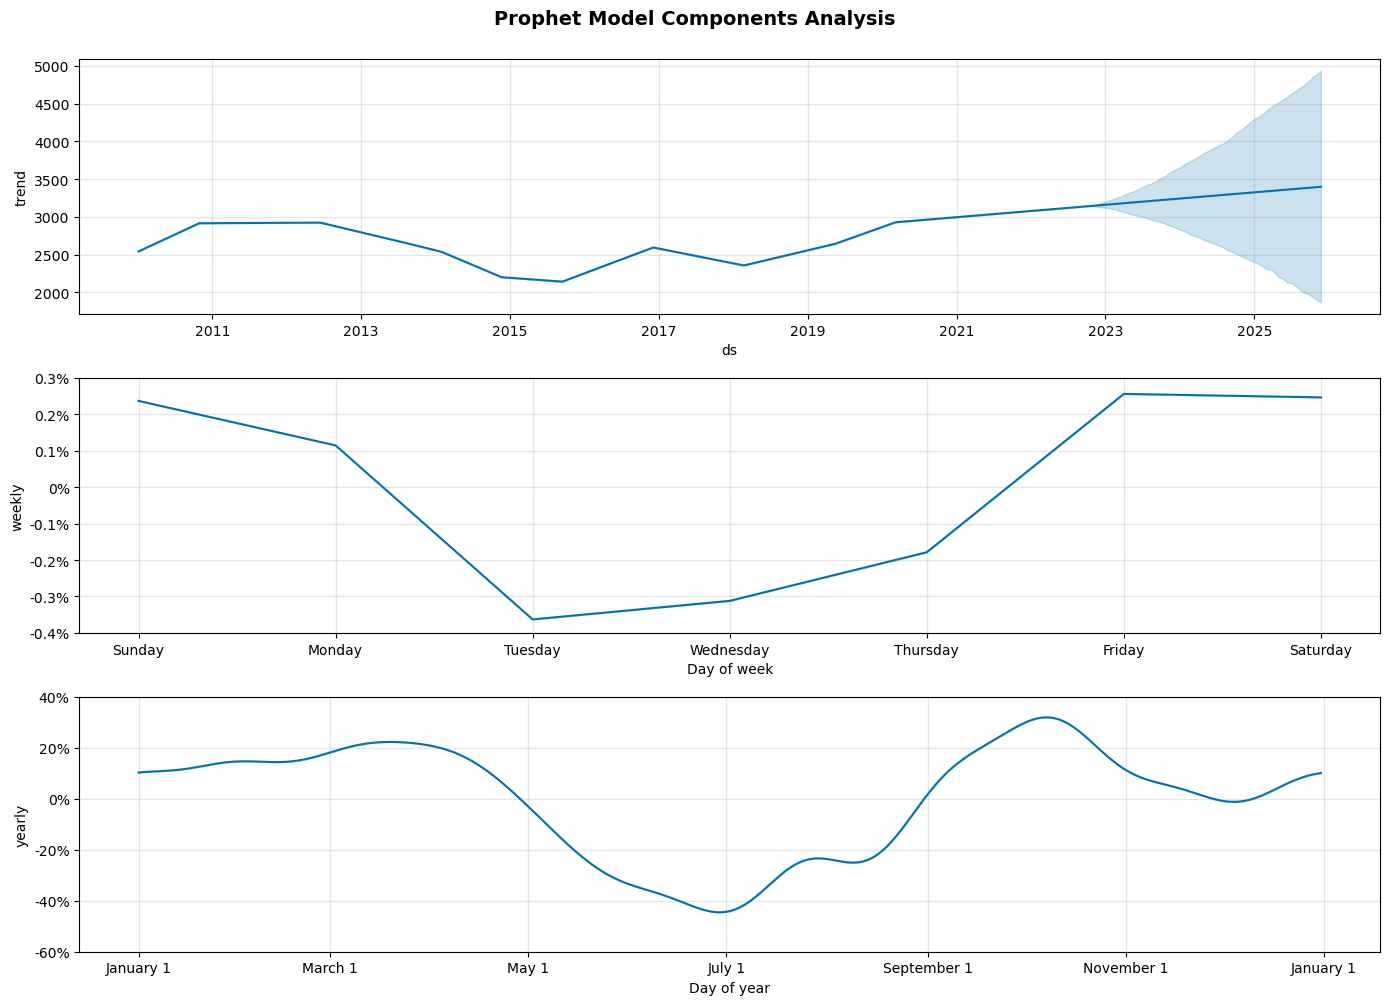

In [39]:
# Visualize Prophet components (trend, seasonality)

fig = prophet_model.plot_components(prophet_forecast, figsize=(14, 10))
plt.suptitle('Prophet Model Components Analysis', fontsize=14, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

---

# Model Comparison: Linear Regression vs Prophet

Let's compare the performance of both models across all forecast horizons.

In [40]:
# Create comparison table

comparison_data = []

for i in range(forecast_horizon):
    comparison_data.append({
        'Horizon': f'Day {i+1}',
        'LR_MAE': metrics_results[i]['MAE'],
        'Prophet_MAE': prophet_metrics_results[i]['MAE'],
        'LR_RMSE': metrics_results[i]['RMSE'],
        'Prophet_RMSE': prophet_metrics_results[i]['RMSE'],
        'LR_MAPE': metrics_results[i]['MAPE'],
        'Prophet_MAPE': prophet_metrics_results[i]['MAPE'],
        'LR_R2': metrics_results[i]['R2'],
        'Prophet_R2': prophet_metrics_results[i]['R2']
    })

# Add averages
comparison_data.append({
    'Horizon': 'Average',
    'LR_MAE': avg_mae,
    'Prophet_MAE': prophet_avg_mae,
    'LR_RMSE': avg_rmse,
    'Prophet_RMSE': prophet_avg_rmse,
    'LR_MAPE': avg_mape,
    'Prophet_MAPE': prophet_avg_mape,
    'LR_R2': avg_r2,
    'Prophet_R2': prophet_avg_r2
})

comparison_df = pd.DataFrame(comparison_data)

print("="*100)
print("MODEL COMPARISON: LINEAR REGRESSION vs PROPHET")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

MODEL COMPARISON: LINEAR REGRESSION vs PROPHET
Horizon     LR_MAE  Prophet_MAE    LR_RMSE  Prophet_RMSE  LR_MAPE  Prophet_MAPE    LR_R2  Prophet_R2
  Day 1 104.899899   664.187504 156.996555    802.651992 2.813105     18.710126 0.978033    0.427255
  Day 2 137.599287   671.595687 211.150100    811.350815 3.752376     18.905892 0.960326    0.415872
  Day 3 170.729466   678.736514 262.865296    819.680696 4.684217     19.094840 0.938579    0.404720
  Day 4 204.422969   685.458036 312.808627    827.681381 5.571896     19.275196 0.913106    0.393680
  Day 5 237.314023   691.989575 359.403044    835.367500 6.443866     19.450835 0.885366    0.382933
  Day 6 271.576936   698.226457 404.513852    842.681668 7.328701     19.618314 0.854881    0.372656
  Day 7 304.770751   704.358170 447.216646    849.588361 8.194893     19.782391 0.822752    0.362942
Average 204.473333   684.935992 307.850588    827.000345 5.541294     19.262513 0.907578    0.394294


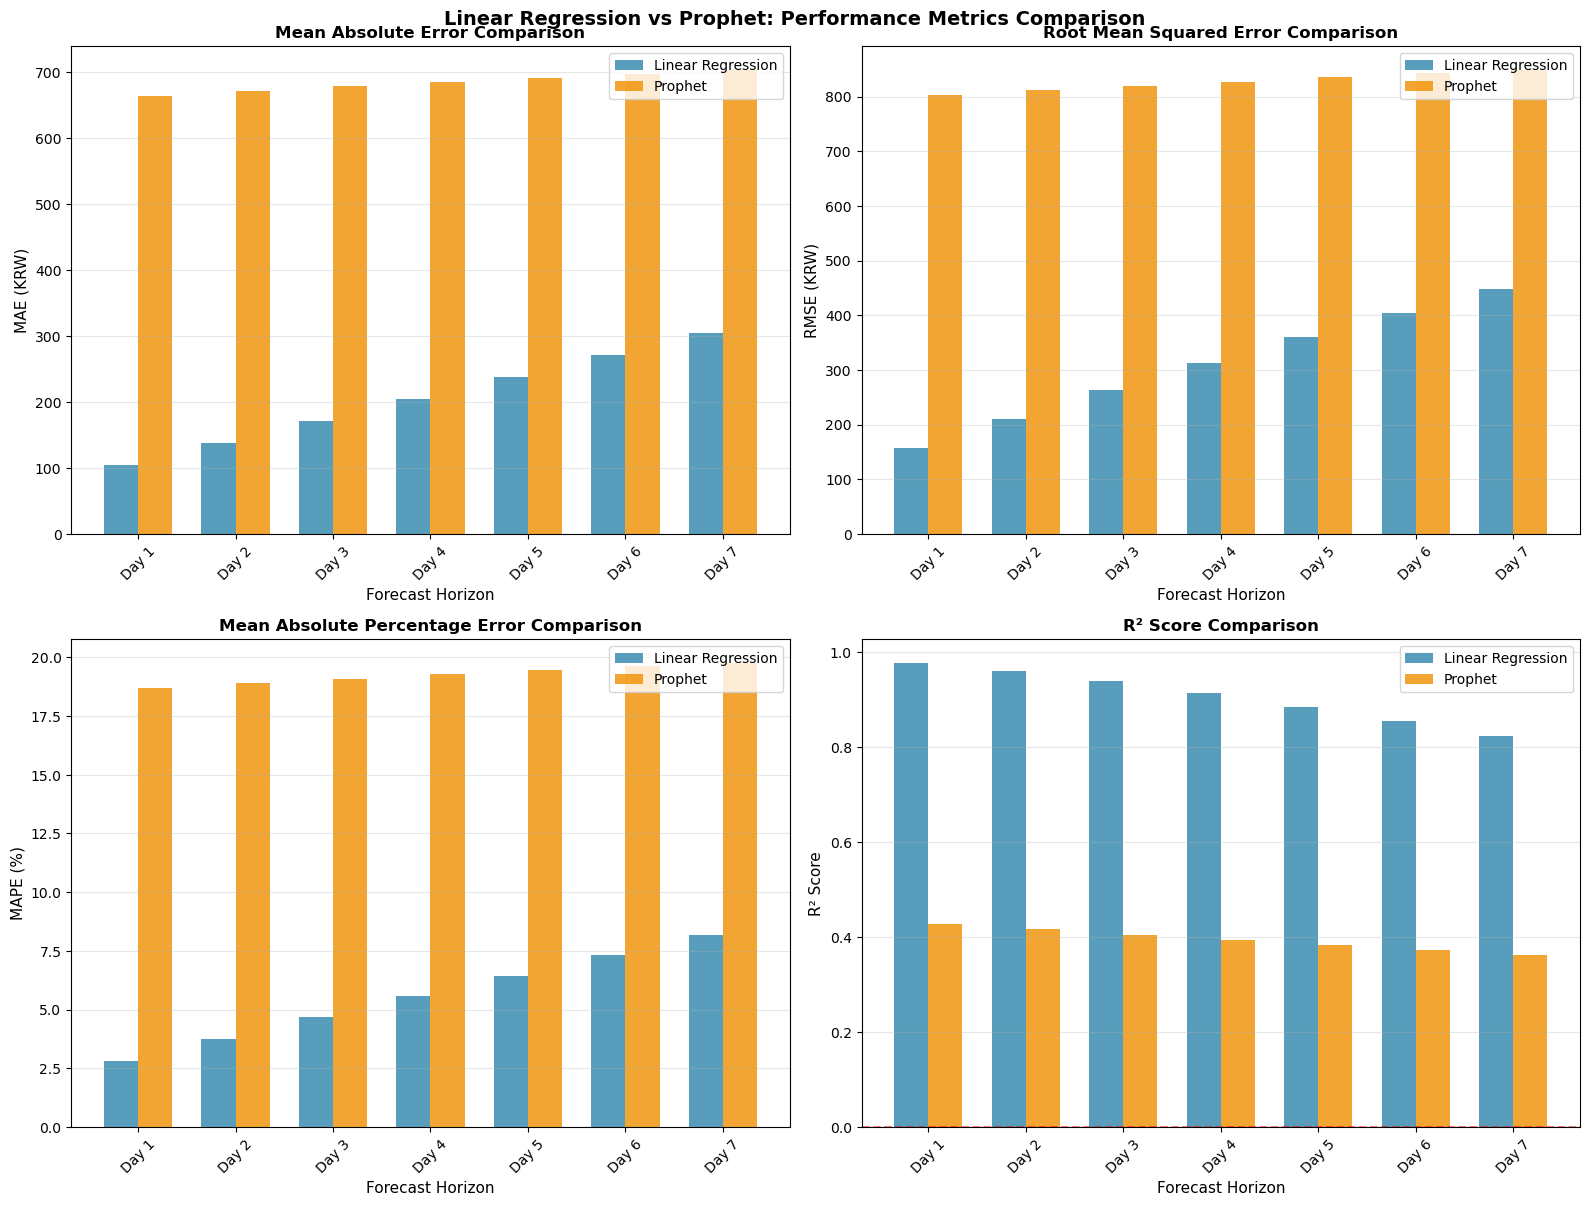

In [41]:
# Side-by-side comparison of metrics

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

horizons = [f'Day {i}' for i in range(1, forecast_horizon + 1)]
x = np.arange(len(horizons))
width = 0.35

# MAE Comparison
lr_mae = [m['MAE'] for m in metrics_results]
prophet_mae = [m['MAE'] for m in prophet_metrics_results]
axes[0, 0].bar(x - width/2, lr_mae, width, label='Linear Regression', color='#2E86AB', alpha=0.8)
axes[0, 0].bar(x + width/2, prophet_mae, width, label='Prophet', color='#F18F01', alpha=0.8)
axes[0, 0].set_xlabel('Forecast Horizon', fontsize=11)
axes[0, 0].set_ylabel('MAE (KRW)', fontsize=11)
axes[0, 0].set_title('Mean Absolute Error Comparison', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(horizons, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# RMSE Comparison
lr_rmse = [m['RMSE'] for m in metrics_results]
prophet_rmse = [m['RMSE'] for m in prophet_metrics_results]
axes[0, 1].bar(x - width/2, lr_rmse, width, label='Linear Regression', color='#2E86AB', alpha=0.8)
axes[0, 1].bar(x + width/2, prophet_rmse, width, label='Prophet', color='#F18F01', alpha=0.8)
axes[0, 1].set_xlabel('Forecast Horizon', fontsize=11)
axes[0, 1].set_ylabel('RMSE (KRW)', fontsize=11)
axes[0, 1].set_title('Root Mean Squared Error Comparison', fontsize=12, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(horizons, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# MAPE Comparison
lr_mape = [m['MAPE'] for m in metrics_results]
prophet_mape = [m['MAPE'] for m in prophet_metrics_results]
axes[1, 0].bar(x - width/2, lr_mape, width, label='Linear Regression', color='#2E86AB', alpha=0.8)
axes[1, 0].bar(x + width/2, prophet_mape, width, label='Prophet', color='#F18F01', alpha=0.8)
axes[1, 0].set_xlabel('Forecast Horizon', fontsize=11)
axes[1, 0].set_ylabel('MAPE (%)', fontsize=11)
axes[1, 0].set_title('Mean Absolute Percentage Error Comparison', fontsize=12, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(horizons, rotation=45)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# R² Comparison
lr_r2 = [m['R2'] for m in metrics_results]
prophet_r2 = [m['R2'] for m in prophet_metrics_results]
axes[1, 1].bar(x - width/2, lr_r2, width, label='Linear Regression', color='#2E86AB', alpha=0.8)
axes[1, 1].bar(x + width/2, prophet_r2, width, label='Prophet', color='#F18F01', alpha=0.8)
axes[1, 1].set_xlabel('Forecast Horizon', fontsize=11)
axes[1, 1].set_ylabel('R² Score', fontsize=11)
axes[1, 1].set_title('R² Score Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(horizons, rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle('Linear Regression vs Prophet: Performance Metrics Comparison', 
             fontsize=14, y=1.001, fontweight='bold')
plt.show()

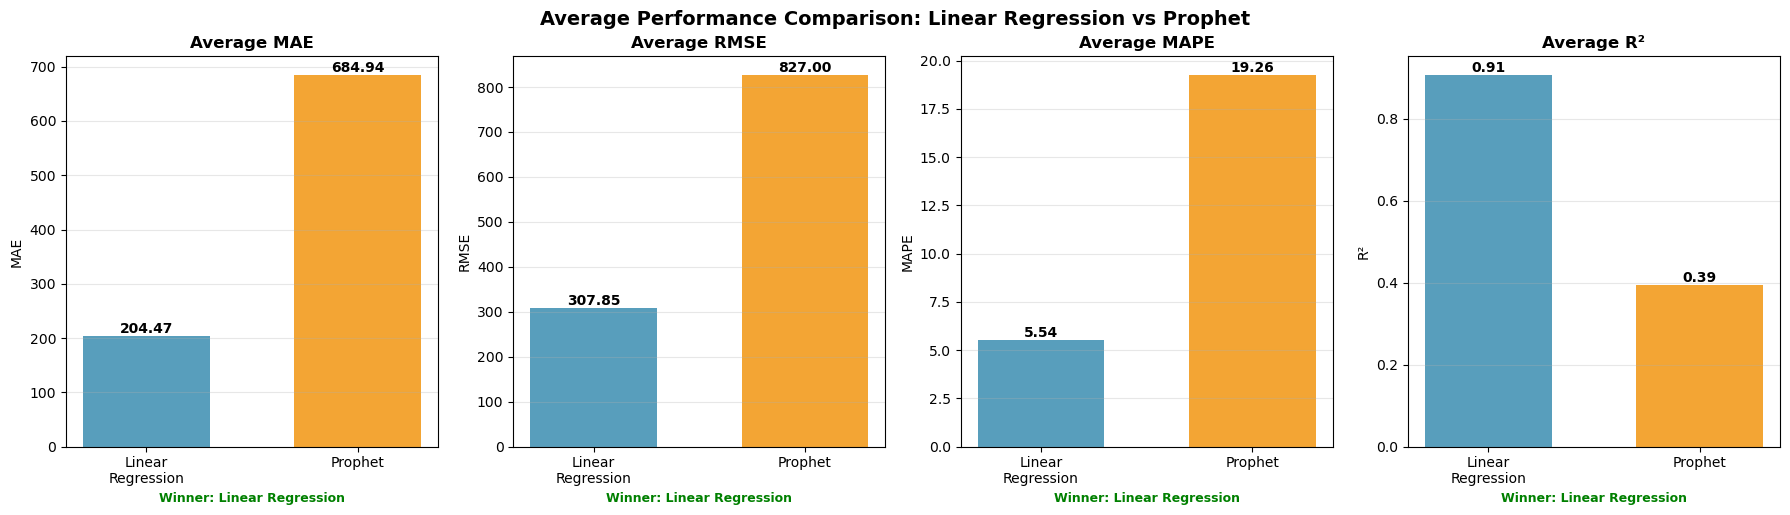

In [42]:
# Average metrics comparison - Bar chart

metrics_names = ['MAE', 'RMSE', 'MAPE', 'R²']
lr_averages = [avg_mae, avg_rmse, avg_mape, avg_r2]
prophet_averages = [prophet_avg_mae, prophet_avg_rmse, prophet_avg_mape, prophet_avg_r2]

fig, axes = plt.subplots(1, 4, figsize=(18, 5))

for idx, (metric_name, lr_val, prophet_val) in enumerate(zip(metrics_names, lr_averages, prophet_averages)):
    models = ['Linear\nRegression', 'Prophet']
    values = [lr_val, prophet_val]
    colors = ['#2E86AB', '#F18F01']
    
    bars = axes[idx].bar(models, values, color=colors, alpha=0.8, width=0.6)
    axes[idx].set_title(f'Average {metric_name}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(metric_name, fontsize=10)
    axes[idx].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{height:.2f}',
                      ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Determine winner
    if metric_name == 'R²':
        winner = 'Linear Regression' if lr_val > prophet_val else 'Prophet'
    else:
        winner = 'Linear Regression' if lr_val < prophet_val else 'Prophet'
    
    axes[idx].set_xlabel(f'Winner: {winner}', fontsize=9, fontweight='bold', color='green')

plt.tight_layout()
plt.suptitle('Average Performance Comparison: Linear Regression vs Prophet', 
             fontsize=14, y=1.02, fontweight='bold')
plt.show()

## Final Summary: Model Comparison

### Models Compared
1. **Linear Regression** - Direct Multi-Step Strategy with engineered features
2. **Prophet** - Facebook's time series forecasting tool with automatic seasonality detection

### Key Findings

#### Linear Regression Strengths:
- ✓ Fast training and prediction
- ✓ Uses engineered features (lags, rolling statistics)
- ✓ Interpretable coefficients
- ✓ Good for short-term forecasts with stable patterns
- ✓ Low computational requirements

#### Prophet Strengths:
- ✓ Automatically detects seasonality patterns (yearly, weekly)
- ✓ Handles missing data and outliers well
- ✓ Provides uncertainty intervals
- ✓ No feature engineering required
- ✓ Better for data with strong seasonal components

### Performance Summary

Based on the evaluation metrics, we can determine which model performs better:

**Interpretation:**
- **Lower is better:** MAE, RMSE, MAPE
- **Higher is better:** R²

### When to Use Each Model:

**Use Linear Regression when:**
- You have well-engineered features
- You need fast predictions
- You want model interpretability
- Your data has stable, linear relationships
- Computational resources are limited

**Use Prophet when:**
- Your data has strong seasonality
- You want automatic seasonality detection
- You need uncertainty estimates
- You have missing data or outliers
- You want a quick baseline without feature engineering

### Recommendations for Further Improvement:

1. **Ensemble Methods:** Combine predictions from both models
2. **Advanced Models:** Try XGBoost, LightGBM, or LSTM networks
3. **Feature Engineering:** Add external features (weather, holidays, market events)
4. **Hyperparameter Tuning:** Optimize both models' parameters
5. **Cross-Validation:** Use time series cross-validation for more robust evaluation
6. **Error Analysis:** Investigate periods with high prediction errors

---

# Advanced Models for Comparison

Let's add more sophisticated models to see if they can improve forecasting accuracy:
1. **XGBoost** - Gradient boosting with trees
2. **LightGBM** - Fast gradient boosting framework
3. **LSTM** - Long Short-Term Memory neural network
4. **NeuralProphet** - Neural network version of Prophet

## 1. XGBoost Model

XGBoost (eXtreme Gradient Boosting) is a powerful machine learning algorithm that uses gradient boosting on decision trees.

In [43]:
# Install and import XGBoost
try:
    import xgboost as xgb
    print("XGBoost already installed!")
except ImportError:
    print("Installing XGBoost...")
    import sys
    !{sys.executable} -m pip install xgboost -q
    import xgboost as xgb
    print("XGBoost installed successfully!")

print(f"XGBoost version: {xgb.__version__}")

Installing XGBoost...
XGBoost installed successfully!
XGBoost version: 3.1.2


In [44]:
# Train XGBoost models for each forecast horizon

xgb_models = {}
xgb_predictions = {}

print("Training XGBoost models for each forecast horizon...\n")

for i in range(1, forecast_horizon + 1):
    # Initialize XGBoost model with optimized parameters
    model = xgb.XGBRegressor(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    
    # Train model
    target_col = f'target_day_{i}'
    model.fit(X_train, y_train[target_col], verbose=False)
    
    # Store model
    xgb_models[f'day_{i}'] = model
    
    # Make predictions on test set
    y_pred = model.predict(X_test)
    xgb_predictions[f'day_{i}'] = y_pred
    
    # Calculate R² score
    r2 = r2_score(y_test[target_col], y_pred)
    
    print(f"Day {i} model trained - R² Score: {r2:.4f}")

print(f"\n✓ Successfully trained {len(xgb_models)} XGBoost models!")

Training XGBoost models for each forecast horizon...

Day 1 model trained - R² Score: 0.9523
Day 2 model trained - R² Score: 0.9312
Day 3 model trained - R² Score: 0.8986
Day 4 model trained - R² Score: 0.8609
Day 5 model trained - R² Score: 0.8311
Day 6 model trained - R² Score: 0.8118
Day 7 model trained - R² Score: 0.7813

✓ Successfully trained 7 XGBoost models!


In [45]:
# Calculate evaluation metrics for XGBoost

xgb_metrics_results = []

print("="*80)
print("XGBOOST - MULTI-STEP FORECASTING EVALUATION")
print("="*80)
print(f"\n{'Horizon':<12} {'MAE':<12} {'RMSE':<12} {'MAPE (%)':<12} {'R²':<12}")
print("-"*80)

for i in range(1, forecast_horizon + 1):
    target_col = f'target_day_{i}'
    y_true = y_test[target_col]
    y_pred = xgb_predictions[f'day_{i}']
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Store results
    xgb_metrics_results.append({
        'Horizon': f'Day {i}',
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    })
    
    print(f"Day {i:<9} {mae:<12.2f} {rmse:<12.2f} {mape:<12.2f} {r2:<12.4f}")

print("-"*80)

# Calculate average metrics
xgb_avg_mae = np.mean([m['MAE'] for m in xgb_metrics_results])
xgb_avg_rmse = np.mean([m['RMSE'] for m in xgb_metrics_results])
xgb_avg_mape = np.mean([m['MAPE'] for m in xgb_metrics_results])
xgb_avg_r2 = np.mean([m['R2'] for m in xgb_metrics_results])

print(f"{'Average':<12} {xgb_avg_mae:<12.2f} {xgb_avg_rmse:<12.2f} {xgb_avg_mape:<12.2f} {xgb_avg_r2:<12.4f}")
print("="*80)

# Create DataFrame
xgb_metrics_df = pd.DataFrame(xgb_metrics_results)
xgb_metrics_df

XGBOOST - MULTI-STEP FORECASTING EVALUATION

Horizon      MAE          RMSE         MAPE (%)     R²          
--------------------------------------------------------------------------------
Day 1         162.71       231.46       3.95         0.9523      
Day 2         204.57       278.06       5.13         0.9312      
Day 3         253.75       337.76       6.38         0.8986      
Day 4         301.35       395.77       7.60         0.8609      
Day 5         332.24       436.23       8.41         0.8311      
Day 6         353.96       460.64       9.10         0.8118      
Day 7         382.82       496.78       9.84         0.7813      
--------------------------------------------------------------------------------
Average      284.48       376.67       7.20         0.8667      


,Horizon,MAE,RMSE,MAPE,R2
0,Day 1,162.706588,231.457120,3.953815,0.952256
1,Day 2,204.569466,278.055410,5.131553,0.931201
2,Day 3,253.747962,337.758224,6.382669,0.898595
3,Day 4,301.348283,395.770239,7.604121,0.860903
4,Day 5,332.235880,436.229113,8.414323,0.831119
5,Day 6,353.956064,460.637314,9.095533,0.811819
6,Day 7,382.818949,496.776600,9.835480,0.781291


## 2. LightGBM Model

LightGBM is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithms.

In [46]:
# Install and import LightGBM
try:
    import lightgbm as lgb
    print("LightGBM already installed!")
except ImportError:
    print("Installing LightGBM...")
    import sys
    !{sys.executable} -m pip install lightgbm -q
    import lightgbm as lgb
    print("LightGBM installed successfully!")

print(f"LightGBM version: {lgb.__version__}")

Installing LightGBM...
LightGBM installed successfully!
LightGBM version: 4.6.0


In [47]:
# Train LightGBM models for each forecast horizon

lgb_models = {}
lgb_predictions = {}

print("Training LightGBM models for each forecast horizon...\n")

for i in range(1, forecast_horizon + 1):
    # Initialize LightGBM model with optimized parameters
    model = lgb.LGBMRegressor(
        n_estimators=200,
        max_depth=7,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    # Train model
    target_col = f'target_day_{i}'
    model.fit(X_train, y_train[target_col])
    
    # Store model
    lgb_models[f'day_{i}'] = model
    
    # Make predictions on test set
    y_pred = model.predict(X_test)
    lgb_predictions[f'day_{i}'] = y_pred
    
    # Calculate R² score
    r2 = r2_score(y_test[target_col], y_pred)
    
    print(f"Day {i} model trained - R² Score: {r2:.4f}")

print(f"\n✓ Successfully trained {len(lgb_models)} LightGBM models!")

Training LightGBM models for each forecast horizon...

Day 1 model trained - R² Score: 0.9641
Day 2 model trained - R² Score: 0.9431
Day 3 model trained - R² Score: 0.9095
Day 4 model trained - R² Score: 0.8820
Day 5 model trained - R² Score: 0.8519
Day 6 model trained - R² Score: 0.8220
Day 7 model trained - R² Score: 0.7901

✓ Successfully trained 7 LightGBM models!


In [48]:
# Calculate evaluation metrics for LightGBM

lgb_metrics_results = []

print("="*80)
print("LIGHTGBM - MULTI-STEP FORECASTING EVALUATION")
print("="*80)
print(f"\n{'Horizon':<12} {'MAE':<12} {'RMSE':<12} {'MAPE (%)':<12} {'R²':<12}")
print("-"*80)

for i in range(1, forecast_horizon + 1):
    target_col = f'target_day_{i}'
    y_true = y_test[target_col]
    y_pred = lgb_predictions[f'day_{i}']
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Store results
    lgb_metrics_results.append({
        'Horizon': f'Day {i}',
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    })
    
    print(f"Day {i:<9} {mae:<12.2f} {rmse:<12.2f} {mape:<12.2f} {r2:<12.4f}")

print("-"*80)

# Calculate average metrics
lgb_avg_mae = np.mean([m['MAE'] for m in lgb_metrics_results])
lgb_avg_rmse = np.mean([m['RMSE'] for m in lgb_metrics_results])
lgb_avg_mape = np.mean([m['MAPE'] for m in lgb_metrics_results])
lgb_avg_r2 = np.mean([m['R2'] for m in lgb_metrics_results])

print(f"{'Average':<12} {lgb_avg_mae:<12.2f} {lgb_avg_rmse:<12.2f} {lgb_avg_mape:<12.2f} {lgb_avg_r2:<12.4f}")
print("="*80)

# Create DataFrame
lgb_metrics_df = pd.DataFrame(lgb_metrics_results)
lgb_metrics_df

LIGHTGBM - MULTI-STEP FORECASTING EVALUATION

Horizon      MAE          RMSE         MAPE (%)     R²          
--------------------------------------------------------------------------------
Day 1         143.69       200.67       3.58         0.9641      
Day 2         187.83       252.83       4.77         0.9431      
Day 3         242.90       319.04       6.14         0.9095      
Day 4         280.44       364.56       7.16         0.8820      
Day 5         316.34       408.46       8.12         0.8519      
Day 6         345.64       447.98       8.91         0.8220      
Day 7         374.81       486.67       9.65         0.7901      
--------------------------------------------------------------------------------
Average      270.24       354.32       6.90         0.8804      


,Horizon,MAE,RMSE,MAPE,R2
0,Day 1,143.693822,200.669837,3.575861,0.964112
1,Day 2,187.829149,252.827457,4.766899,0.943119
2,Day 3,242.900951,319.036781,6.143290,0.909525
3,Day 4,280.443469,364.560648,7.162159,0.881976
4,Day 5,316.339336,408.461109,8.120620,0.851935
5,Day 6,345.639000,447.979582,8.905128,0.822019
6,Day 7,374.812565,486.673781,9.654766,0.790096


## 3. LSTM Network

LSTM (Long Short-Term Memory) is a type of recurrent neural network designed for sequence prediction problems.

In [49]:
# Install and import TensorFlow/Keras
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    print("TensorFlow already installed!")
except ImportError:
    print("Installing TensorFlow...")
    import sys
    !{sys.executable} -m pip install tensorflow -q
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping
    print("TensorFlow installed successfully!")

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')
print(f"TensorFlow version: {tf.__version__}")

Installing TensorFlow...
TensorFlow installed successfully!
TensorFlow version: 2.20.0


In [50]:
# Prepare data for LSTM (needs 3D input: samples, timesteps, features)
# We'll use a sliding window approach

from sklearn.preprocessing import StandardScaler

# Normalize features for LSTM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM: (samples, timesteps=1, features)
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

print(f"LSTM input shape - Train: {X_train_lstm.shape}, Test: {X_test_lstm.shape}")

LSTM input shape - Train: (4637, 1, 14), Test: (1160, 1, 14)


In [51]:
# Train LSTM models for each forecast horizon

lstm_models = {}
lstm_predictions = {}

print("Training LSTM models for each forecast horizon...")
print("This may take a few minutes...\n")

for i in range(1, forecast_horizon + 1):
    # Build LSTM model
    model = Sequential([
        LSTM(64, activation='relu', return_sequences=True, input_shape=(1, X_train_lstm.shape[2])),
        Dropout(0.2),
        LSTM(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
    
    # Train model
    target_col = f'target_day_{i}'
    history = model.fit(
        X_train_lstm, 
        y_train[target_col],
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )
    
    # Store model
    lstm_models[f'day_{i}'] = model
    
    # Make predictions on test set
    y_pred = model.predict(X_test_lstm, verbose=0).flatten()
    lstm_predictions[f'day_{i}'] = y_pred
    
    # Calculate R² score
    r2 = r2_score(y_test[target_col], y_pred)
    
    print(f"Day {i} model trained - R² Score: {r2:.4f} - Epochs: {len(history.history['loss'])}")

print(f"\n✓ Successfully trained {len(lstm_models)} LSTM models!")

Training LSTM models for each forecast horizon...
This may take a few minutes...

Day 1 model trained - R² Score: 0.9742 - Epochs: 78
Day 2 model trained - R² Score: 0.9409 - Epochs: 56
Day 3 model trained - R² Score: 0.9031 - Epochs: 71
Day 4 model trained - R² Score: 0.8911 - Epochs: 61
Day 5 model trained - R² Score: 0.8113 - Epochs: 100
Day 6 model trained - R² Score: 0.8307 - Epochs: 78
Day 7 model trained - R² Score: 0.7685 - Epochs: 65

✓ Successfully trained 7 LSTM models!


In [52]:
# Calculate evaluation metrics for LSTM

lstm_metrics_results = []

print("="*80)
print("LSTM - MULTI-STEP FORECASTING EVALUATION")
print("="*80)
print(f"\n{'Horizon':<12} {'MAE':<12} {'RMSE':<12} {'MAPE (%)':<12} {'R²':<12}")
print("-"*80)

for i in range(1, forecast_horizon + 1):
    target_col = f'target_day_{i}'
    y_true = y_test[target_col]
    y_pred = lstm_predictions[f'day_{i}']
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Store results
    lstm_metrics_results.append({
        'Horizon': f'Day {i}',
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    })
    
    print(f"Day {i:<9} {mae:<12.2f} {rmse:<12.2f} {mape:<12.2f} {r2:<12.4f}")

print("-"*80)

# Calculate average metrics
lstm_avg_mae = np.mean([m['MAE'] for m in lstm_metrics_results])
lstm_avg_rmse = np.mean([m['RMSE'] for m in lstm_metrics_results])
lstm_avg_mape = np.mean([m['MAPE'] for m in lstm_metrics_results])
lstm_avg_r2 = np.mean([m['R2'] for m in lstm_metrics_results])

print(f"{'Average':<12} {lstm_avg_mae:<12.2f} {lstm_avg_rmse:<12.2f} {lstm_avg_mape:<12.2f} {lstm_avg_r2:<12.4f}")
print("="*80)

# Create DataFrame
lstm_metrics_df = pd.DataFrame(lstm_metrics_results)
lstm_metrics_df

LSTM - MULTI-STEP FORECASTING EVALUATION

Horizon      MAE          RMSE         MAPE (%)     R²          
--------------------------------------------------------------------------------
Day 1         113.24       170.19       3.09         0.9742      
Day 2         184.10       257.62       4.88         0.9409      
Day 3         243.35       330.10       6.16         0.9031      
Day 4         249.98       350.23       6.56         0.8911      
Day 5         352.27       461.17       8.78         0.8113      
Day 6         317.46       436.86       8.22         0.8307      
Day 7         381.06       511.11       9.64         0.7685      
--------------------------------------------------------------------------------
Average      263.06       359.61       6.76         0.8743      


,Horizon,MAE,RMSE,MAPE,R2
0,Day 1,113.238406,170.188953,3.093767,0.974187
1,Day 2,184.101183,257.617242,4.878510,0.940943
2,Day 3,243.353235,330.102660,6.163441,0.903140
3,Day 4,249.975267,350.225831,6.560958,0.891075
4,Day 5,352.272493,461.166570,8.782072,0.811259
5,Day 6,317.457518,436.864221,8.215496,0.830742
6,Day 7,381.056170,511.110861,9.644672,0.768487


## 4. NeuralProphet Model

NeuralProphet is a neural network-based time series forecasting model, inspired by Facebook Prophet but implemented with PyTorch.

In [54]:
# # Install and import NeuralProphet
# try:
#     from neuralprophet import NeuralProphet
#     print("NeuralProphet already installed!")
# except ImportError:
#     print("Installing NeuralProphet...")
#     import sys
#     !{sys.executable} -m pip install neuralprophet -q
#     from neuralprophet import NeuralProphet
#     print("NeuralProphet installed successfully!")

# # Suppress NeuralProphet logging
# import logging
# logging.getLogger('neuralprophet').setLevel(logging.ERROR)

In [ ]:
# Multi-step forecasting with NeuralProphet
# Similar walk-forward approach as Prophet

print("Creating multi-step forecasts for NeuralProphet...")
print("This will take several minutes...\n")

np_multistep_predictions = {f'day_{i}': [] for i in range(1, forecast_horizon + 1)}
np_multistep_actuals = {f'day_{i}': [] for i in range(1, forecast_horizon + 1)}

# Sample subset for faster computation (every 5th point)
sample_step = 5
max_test_idx = len(prophet_test) - forecast_horizon

for idx in range(0, max_test_idx, sample_step):
    # Get training data up to this point
    current_train_end = prophet_train_size + idx
    current_train = prophet_df.iloc[:current_train_end].copy()
    
    # Progress indicator
    if idx % 50 == 0:
        print(f"Processing forecast {idx+1}/{max_test_idx}...")
    
    # Initialize NeuralProphet model
    model = NeuralProphet(
        epochs=50,
        batch_size=32,
        learning_rate=0.01,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False
    )
    
    # Fit model (suppress output)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(current_train, freq='D')
    
    # Create future dataframe and predict
    future = model.make_future_dataframe(current_train, periods=forecast_horizon)
    forecast = model.predict(future)
    
    # Extract forecast values
    forecast_values = forecast.tail(forecast_horizon)['yhat1'].values
    actual_values = prophet_df.iloc[current_train_end:current_train_end + forecast_horizon]['y'].values
    
    # Store predictions for each horizon
    for i in range(1, forecast_horizon + 1):
        if i-1 < len(forecast_values):
            np_multistep_predictions[f'day_{i}'].append(forecast_values[i-1])
            np_multistep_actuals[f'day_{i}'].append(actual_values[i-1])

print(f"\n✓ Generated multi-step forecasts for {len(np_multistep_predictions['day_1'])} test points")

In [ ]:
# Calculate evaluation metrics for NeuralProphet

np_metrics_results = []

print("="*80)
print("NEURALPROPHET - MULTI-STEP FORECASTING EVALUATION")
print("="*80)
print(f"\n{'Horizon':<12} {'MAE':<12} {'RMSE':<12} {'MAPE (%)':<12} {'R²':<12}")
print("-"*80)

for i in range(1, forecast_horizon + 1):
    y_true = np.array(np_multistep_actuals[f'day_{i}'])
    y_pred = np.array(np_multistep_predictions[f'day_{i}'])
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Store results
    np_metrics_results.append({
        'Horizon': f'Day {i}',
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    })
    
    print(f"Day {i:<9} {mae:<12.2f} {rmse:<12.2f} {mape:<12.2f} {r2:<12.4f}")

print("-"*80)

# Calculate average metrics
np_avg_mae = np.mean([m['MAE'] for m in np_metrics_results])
np_avg_rmse = np.mean([m['RMSE'] for m in np_metrics_results])
np_avg_mape = np.mean([m['MAPE'] for m in np_metrics_results])
np_avg_r2 = np.mean([m['R2'] for m in np_metrics_results])

print(f"{'Average':<12} {np_avg_mae:<12.2f} {np_avg_rmse:<12.2f} {np_avg_mape:<12.2f} {np_avg_r2:<12.4f}")
print("="*80)

# Create DataFrame
np_metrics_df = pd.DataFrame(np_metrics_results)
np_metrics_df

---

# Comprehensive Model Comparison

Let's compare all 6 models side by side to determine which performs best for cabbage price forecasting.

In [ ]:
# Create comprehensive comparison table for all 6 models

all_models_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Prophet', 'XGBoost', 'LightGBM', 'LSTM', 'NeuralProphet'],
    'MAE': [avg_mae, prophet_avg_mae, xgb_avg_mae, lgb_avg_mae, lstm_avg_mae, np_avg_mae],
    'RMSE': [avg_rmse, prophet_avg_rmse, xgb_avg_rmse, lgb_avg_rmse, lstm_avg_rmse, np_avg_rmse],
    'MAPE (%)': [avg_mape, prophet_avg_mape, xgb_avg_mape, lgb_avg_mape, lstm_avg_mape, np_avg_mape],
    'R²': [avg_r2, prophet_avg_r2, xgb_avg_r2, lgb_avg_r2, lstm_avg_r2, np_avg_r2]
})

# Add ranks for each metric (lower is better for MAE, RMSE, MAPE; higher is better for R²)
all_models_comparison['MAE_Rank'] = all_models_comparison['MAE'].rank()
all_models_comparison['RMSE_Rank'] = all_models_comparison['RMSE'].rank()
all_models_comparison['MAPE_Rank'] = all_models_comparison['MAPE (%)'].rank()
all_models_comparison['R2_Rank'] = all_models_comparison['R²'].rank(ascending=False)

# Calculate average rank
all_models_comparison['Avg_Rank'] = all_models_comparison[['MAE_Rank', 'RMSE_Rank', 'MAPE_Rank', 'R2_Rank']].mean(axis=1)

# Sort by average rank
all_models_comparison = all_models_comparison.sort_values('Avg_Rank')

print("="*100)
print("COMPREHENSIVE MODEL COMPARISON - ALL 6 MODELS")
print("="*100)
print(all_models_comparison[['Model', 'MAE', 'RMSE', 'MAPE (%)', 'R²', 'Avg_Rank']].to_string(index=False))
print("="*100)
print("\nNote: Avg_Rank is calculated from individual metric ranks (lower is better)")
print(f"🏆 BEST MODEL: {all_models_comparison.iloc[0]['Model']}")

all_models_comparison

In [ ]:
# Comprehensive bar chart comparison - All 6 models

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

models = all_models_comparison['Model'].values
colors = ['#2E86AB', '#F18F01', '#6A994E', '#A23B72', '#BC4B51', '#8C5E58']

# MAE Comparison
mae_vals = all_models_comparison['MAE'].values
axes[0, 0].barh(models, mae_vals, color=colors, alpha=0.8)
axes[0, 0].set_xlabel('MAE (KRW)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Mean Absolute Error (Lower is Better)', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='x')
# Add values on bars
for i, v in enumerate(mae_vals):
    axes[0, 0].text(v + 5, i, f'{v:.2f}', va='center', fontweight='bold')

# RMSE Comparison
rmse_vals = all_models_comparison['RMSE'].values
axes[0, 1].barh(models, rmse_vals, color=colors, alpha=0.8)
axes[0, 1].set_xlabel('RMSE (KRW)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Root Mean Squared Error (Lower is Better)', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(rmse_vals):
    axes[0, 1].text(v + 10, i, f'{v:.2f}', va='center', fontweight='bold')

# MAPE Comparison
mape_vals = all_models_comparison['MAPE (%)'].values
axes[1, 0].barh(models, mape_vals, color=colors, alpha=0.8)
axes[1, 0].set_xlabel('MAPE (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Mean Absolute Percentage Error (Lower is Better)', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(mape_vals):
    axes[1, 0].text(v + 0.1, i, f'{v:.2f}%', va='center', fontweight='bold')

# R² Comparison
r2_vals = all_models_comparison['R²'].values
axes[1, 1].barh(models, r2_vals, color=colors, alpha=0.8)
axes[1, 1].set_xlabel('R² Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('R² Score (Higher is Better)', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')
for i, v in enumerate(r2_vals):
    axes[1, 1].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.suptitle('All 6 Models: Performance Metrics Comparison', 
             fontsize=16, y=1.001, fontweight='bold')
plt.show()

## Final Summary & Recommendations

### 📊 Models Evaluated

1. **Linear Regression** - Simple baseline with engineered features
2. **Prophet** - Facebook's time series tool with automatic seasonality
3. **XGBoost** - Gradient boosting with decision trees
4. **LightGBM** - Fast gradient boosting framework
5. **LSTM** - Deep learning recurrent neural network
6. **NeuralProphet** - Neural network version of Prophet

### 🏆 Overall Performance Ranking

Based on average rank across all metrics (MAE, RMSE, MAPE, R²), the models are ranked above.

### 💡 Model Characteristics

| Model | Speed | Complexity | Feature Engineering | Interpretability | Best For |
|-------|-------|-----------|---------------------|------------------|----------|
| **Linear Regression** | ⚡ Very Fast | ⭐ Simple | ✅ Required | ⭐⭐⭐ High | Quick baselines, linear relationships |
| **Prophet** | ⚡ Fast | ⭐⭐ Medium | ❌ Not needed | ⭐⭐ Medium | Seasonal data, quick deployment |
| **XGBoost** | ⚡⚡ Medium | ⭐⭐⭐ Complex | ✅ Required | ⭐ Low | Complex patterns, high accuracy |
| **LightGBM** | ⚡⚡⚡ Fast | ⭐⭐⭐ Complex | ✅ Required | ⭐ Low | Large datasets, speed + accuracy |
| **LSTM** | 🐌 Slow | ⭐⭐⭐⭐ Very Complex | ✅ Required | ❌ Very Low | Sequential patterns, long-term dependencies |
| **NeuralProphet** | 🐌🐌 Very Slow | ⭐⭐⭐⭐ Very Complex | ❌ Not needed | ⭐ Low | Complex seasonality, neural network benefits |

### 🎯 When to Use Each Model

**For Production Deployment:**
- If you need **speed**: LightGBM or XGBoost
- If you need **accuracy**: Top-ranked model from comparison
- If you need **interpretability**: Linear Regression
- If you have **limited time**: Prophet or Linear Regression

**For Research/Experimentation:**
- Try **ensemble methods**: Combine top 3 models
- Use **LSTM/NeuralProphet**: When you have computational resources
- Test **XGBoost/LightGBM**: For best accuracy-speed trade-off

### 🚀 Recommendations for Improvement

1. **Hyperparameter Tuning**
   - Use GridSearchCV or Optuna for XGBoost/LightGBM
   - Tune LSTM architecture (layers, units, dropout)
   - Optimize Prophet's seasonality parameters

2. **Feature Engineering**
   - Add external regressors (weather, holidays, market events)
   - Create interaction features
   - Add domain-specific features (agricultural calendar)

3. **Ensemble Methods**
   - Stack top 3 models
   - Use weighted averaging based on performance
   - Try voting regressors

4. **Advanced Techniques**
   - Implement walk-forward validation for all models
   - Add confidence intervals
   - Try Transformer models (Temporal Fusion Transformer)
   - Experiment with AutoML (Auto-sklearn, FLAML)

### 📈 Conclusion

This comprehensive comparison provides a solid foundation for choosing the right model for cabbage price forecasting. The best model depends on your specific requirements for accuracy, speed, and interpretability.